# Relax_challenge

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

import time
from datetime import timedelta


from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

## Load data

In [2]:
takehome_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
takehome_user_engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

In [3]:
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Data Wrangling

### 1.takehome_user_engagement

In [6]:
takehome_user_engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [7]:
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])

In [8]:
print('Total login = {}, user = {}'.format
      (len(takehome_user_engagement), takehome_user_engagement['user_id'].nunique()))

Total login = 207917, user = 8823


Funtion for our goal

In [9]:
def logins_in_days(takehome_user_engagement, days=7, logins=3):
    takehome_user_engagement['date'] = takehome_user_engagement['time_stamp'].dt.date
    takehome_user_engagement = takehome_user_engagement.drop_duplicates(subset='date').sort_values('date')
    passed_days = takehome_user_engagement['date'].diff(periods = logins-1)
    return any(passed_days <= timedelta(days=days))

run the function

In [10]:
adopted = takehome_user_engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [11]:
len(adopted)

8823

In [12]:
sum(adopted)

1656

### 2.takehome_users

In [13]:
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [14]:
takehome_users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [15]:
takehome_users['creation_time'] = pd.to_datetime(takehome_users['creation_time'])
takehome_users['last_session_creation_time'] = pd.to_datetime(takehome_users['last_session_creation_time'], unit='s')

In [16]:
takehome_users['history'] = takehome_users['last_session_creation_time'] - takehome_users['creation_time']
takehome_users['history'] = takehome_users['history'].dt.days

In [17]:
latest = max(takehome_users['creation_time'])
takehome_users['account_age'] = latest - takehome_users['creation_time']
takehome_users['account_age'] = takehome_users['account_age'].dt.days
takehome_users = takehome_users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [18]:
takehome_users = takehome_users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [19]:
takehome_users

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,0.0,38
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,136.0,196
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,0.0,437
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1.0,374
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,5.0,498
...,...,...,...,...,...,...,...,...
11995,11996,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,0,0,0.0,266
11996,11997,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,0,0,5.0,505
11997,11998,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1,1,0.0,33
11998,11999,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,0,0,2.0,729


In [20]:
takehome_users.rename(columns={'object_id': 'user_id'}, inplace=True)

In [21]:
takehome_users = takehome_users.set_index('user_id')

In [22]:
takehome_user_engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [23]:
mix_data = pd.concat([takehome_users, adopted], join='inner', axis=1)

In [24]:
mix_data.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age,adopted_user
user_id,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,0.0,38,False
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,136.0,196,True
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,0.0,437,False
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1.0,374,False
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,5.0,498,False


In [25]:
mix_data['adopted_user'] = mix_data['adopted_user'].astype('int')

## Exploratory Data Analysis

In [26]:
mix_data["creation_source"].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

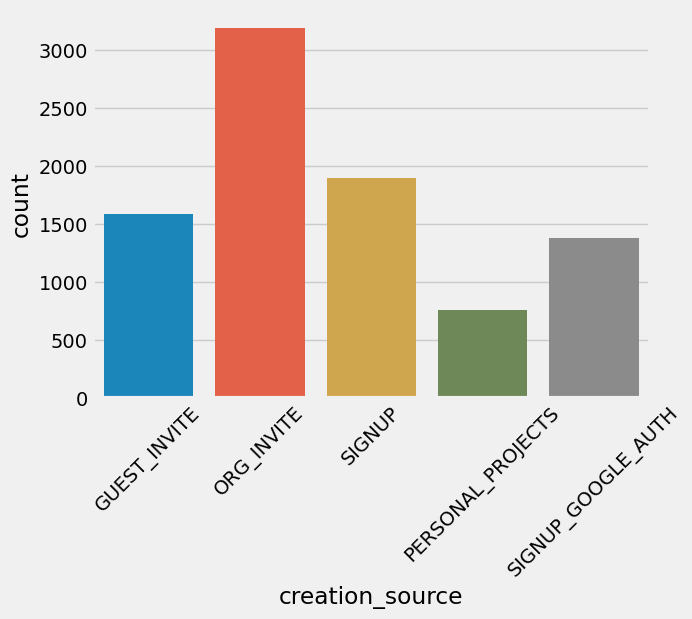

In [27]:
sns.countplot(x='creation_source', data=mix_data)
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

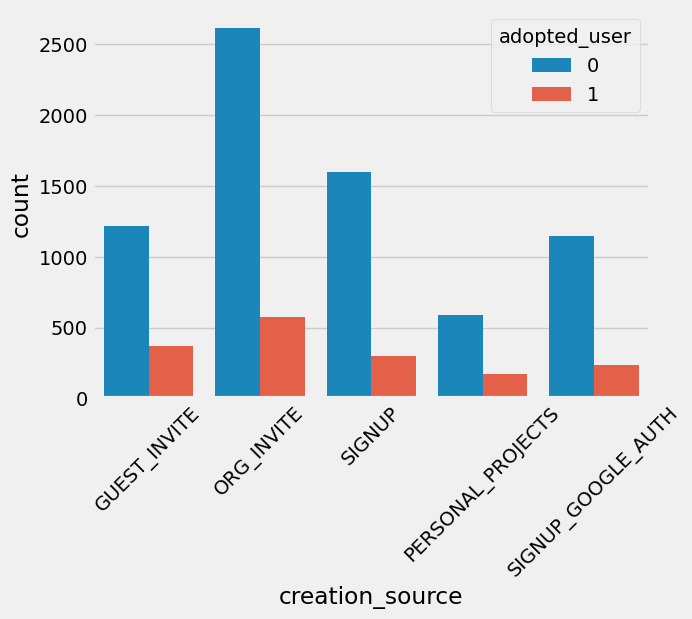

In [28]:
sns.countplot(x='creation_source', data=mix_data, hue='adopted_user')
plt.xticks(rotation = 45)

## Modeling

In [29]:
mix_data_prepared = mix_data.drop(columns=['name', 'email'], axis=1)
mix_data_prepared.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age,adopted_user
user_id,,,,,,
1,GUEST_INVITE,1,0,0.0,38,0
2,ORG_INVITE,0,0,136.0,196,1
3,ORG_INVITE,0,0,0.0,437,0
4,GUEST_INVITE,0,0,1.0,374,0
5,GUEST_INVITE,0,0,5.0,498,0


In [30]:
# make dummy variable for creation source
creation_source = pd.get_dummies(mix_data_prepared['creation_source'], drop_first=True)
model_data = pd.concat([mix_data_prepared, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)
# though account_age and history have different scales than other features,
# I plan to use random forest model, which is not affectd by the different scales
# no need to scale the data
# create training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [31]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.9623700369708137


In [32]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [33]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.895648
account_age                   0.088648
opted_in_to_mailing_list      0.003301
SIGNUP                        0.003050
enabled_for_marketing_drip    0.002900
ORG_INVITE                    0.002355
PERSONAL_PROJECTS             0.002157
SIGNUP_GOOGLE_AUTH            0.001942
dtype: float64


History is the most important feature in our data.

ORG_INVITE and PERSONAL_PROJECTS are the most important features in creation source. it means that people who were invited were more important. So we should try to make users to invite more people to share.